# Regression tasks

In this notebook, we shift from classification to regression modeling in order to predict continuous ESG-related outcomes.
While the classification tasks focused on assigning companies to discrete ESG categories (Low, Moderate, High), regression allows us to explore a different perspective:
how well can machine learning models estimate continuous ESG scores or financial indicators based on a company’s ESG sub-scores, environmental efficiency metrics, and financial characteristics?

This section aims to:

- Model continuous targets such as ESG_Overall, MarketCap, or Revenue.

- Evaluate different regression algorithms.

- Assess predictive performance using appropriate regression metrics (MAE, RMSE, R²).

- Analyze residuals to understand model behavior.

- Interpret feature contributions and relationships between ESG and financial performance.

By complementing the earlier classification results, the regression analysis provides a deeper, more granular understanding of how ESG dimensions relate to financial and sustainability outcomes in the dataset

## Library imports

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Dataset manipulations

In [2]:
df = pd.read_csv('company_esg_financial_dataset.csv')
df['GrowthRate'] = df['GrowthRate'].fillna(0)
df.head()

,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,0.0,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.9,32.8,78.5,37314.7,18657.4,74629.4
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,57.6,34.0,77.8,45006.4,22503.2,90012.9
3,1,Company_1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,62.3,33.4,78.3,42650.1,21325.1,85300.2
4,1,Company_1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,63.7,30.0,76.1,41799.4,20899.7,83598.8


## Predicting ESG_Overall

### Linear Regression

We begin our regression analysis by predicting the continuous variable `ESG_Overall` using only non-ESG numerical
predictors. This choice avoids trivial linear dependence with the ESG sub-scores, ensuring that the model learns from
financial variables, environmental efficiency indicators, and contextual attributes.

The regression pipeline mirrors the classification workflow: preprocessing, standardization of numeric features, and
an 60/20/20 train–validation–test split. We evaluate the model using R², MAE, and RMSE to assess goodness of fit and
prediction error.

#### Preparation of the data

In [4]:
# Copy dataset
df_reg = df.copy()

# Create engineered features
df_reg['EmissionsPerRevenue'] = df_reg['CarbonEmissions'] / df_reg['Revenue']
df_reg['LogMarketCap'] = np.log1p(df_reg['MarketCap'])
df_reg['LogRevenue'] = np.log1p(df_reg['Revenue'])

# One-hot encoding
df_reg = pd.get_dummies(df_reg, columns=['Industry', 'Region'], drop_first=True)

# Selection of the features (NO ESG sub-scores)
reg_features = [
    'LogRevenue', 'ProfitMargin', 'LogMarketCap', 'GrowthRate',
    'EmissionsPerRevenue', 'WaterUsage', 'EnergyConsumption'
]

# one-hot encoded industry/region
reg_features += [c for c in df_reg.columns if c.startswith('Industry_') or c.startswith('Region_')]

# Target = ESG_Overall
X = df_reg[reg_features].values
y = df_reg['ESG_Overall'].values

# Train/Val/Test split: 60/20/20
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# standardize numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (6600, 21) Val: (2200, 21) Test: (2200, 21)


#### Train linear regression and evaluation

In [ ]:
# train linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# predictions
y_pred = linreg.predict(X_test)

# metrics
r2  = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression Results:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

Linear Regression Results:
R² Score: 0.5367
MAE: 8.3482
RMSE: 10.4578


#### Interpretation of Linear Regression Results

The linear regression model achieves an R² score of **0.5367**, meaning that it explains about **54% of the variance** in the continuous `ESG_Overall` score using only non-ESG predictors. This indicates a moderate linear relationship but also shows that a substantial portion of the variability remains unexplained by a simple linear model.

The error metrics support this observation:

- **MAE = 8.35** : on average, predictions deviate by approximately 8 ESG points.
- **RMSE = 10.46** : larger errors are more penalized, indicating some significant deviations.

These results suggest that the relationship between operational efficiency metrics, financial attributes, and the aggregated ESG score is **not strictly linear**. More flexible regression models—such as Ridge/Lasso, Random Forest Regressor, or XGBoost Regressor—are likely needed to capture the non-linear interactions present in the data.


#### Visualisations

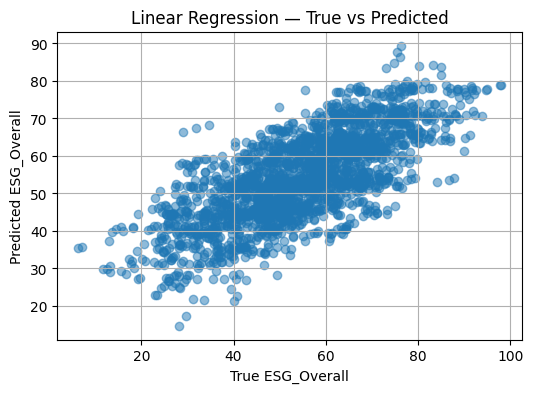

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True ESG_Overall")
plt.ylabel("Predicted ESG_Overall")
plt.title("Linear Regression — True vs Predicted")
plt.grid(True)
plt.show()


The scatter plot shows that the linear regression model captures the general upward trend of `ESG_Overall`, but the points remain widely dispersed around the ideal diagonal line. This indicates that the model only partially explains the variance: it tends to **underestimate high scores** and **overestimate low scores**, reflecting its difficulty in modeling the non-linear relationships in the data. Overall, the plot confirms the moderate performance seen in the metrics (R² ≈ 0.54).








#### Ridge Regression (L2 Regularization)
Ridge Regression extends linear regression by adding L2 regularization, which helps stabilize coefficients and reduce
overfitting in the presence of multicollinearity. Since our predictors include several correlated financial and
environmental indicators, Ridge offers a more robust alternative to plain linear regression.

In [ ]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
r2_ridge  = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print("Ridge Regression Results:")
print(f"R² Score: {r2_ridge:.4f}")
print(f"MAE: {mae_ridge:.4f}")
print(f"RMSE: {rmse_ridge:.4f}")


Ridge Regression Results:
R² Score: 0.5367
MAE: 8.3454
RMSE: 10.4569


#### Lasso Regression (L1 Regularization)
Lasso Regression applies L1 regularization, which can shrink some coefficients to zero. This makes it useful for
feature selection and identifying the most influential predictors. In our ESG regression setup, Lasso helps determine
whether only a subset of financial or environmental indicators drives `ESG_Overall`.

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
r2_lasso  = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print("Lasso Regression Results:")
print(f"R² Score: {r2_lasso:.4f}")
print(f"MAE: {mae_lasso:.4f}")
print(f"RMSE: {rmse_lasso:.4f}")


Lasso Regression Results:
R² Score: 0.5372
MAE: 8.3349
RMSE: 10.4516


Ridge and Lasso regression perform almost identically to standard linear regression, with R² scores around **0.536–0.537** and similar MAE and RMSE values. This shows that regularization does not meaningfully improve performance, as the limitation comes from the **linear nature of the model**, not from coefficient instability. Financial and environmental predictors alone cannot fully capture the non-linear structure behind ESG_Overall, confirming the need for more flexible nonlinear regressors.


### Decision Tree

#### Decision Tree Regression — Training Procedure

We trained a Decision Tree Regressor to model the continuous `ESG_Overall` score using financial and environmental predictors. The tree was grown without depth limitation (`max_depth=None`), allowing it to fully adapt to the training data but increasing the risk of overfitting. After fitting the model on the training set, predictions on the test set were evaluated using R², MAE, and RMSE to quantify its explanatory power and prediction error.


In [ ]:
tree_reg = DecisionTreeRegressor(
    max_depth=None,        # will likely overfit
    min_samples_leaf=1,
    random_state=42
)

tree_reg.fit(X_train, y_train)

y_pred_tree = tree_reg.predict(X_test)

r2_tree = r2_score(y_test, y_pred_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))

print("Decision Tree Regression Results:")
print(f"R² Score: {r2_tree:.4f}")
print(f"MAE: {mae_tree:.4f}")
print(f"RMSE: {rmse_tree:.4f}")

Decision Tree Regression Results:
R² Score: 0.6206
MAE: 5.7437
RMSE: 9.4631


#### Decision Tree Regression — Model Performance

The Decision Tree Regressor provides a noticeable improvement over linear models by capturing nonlinear relationships between financial and environmental predictors and the continuous `ESG_Overall` score. However, despite its flexibility, the model still shows signs of overfitting due to its unconstrained depth.

**Performance Metrics (Test Set):**

- **R² Score:** 0.6206  
- **MAE:** 5.7437  
- **RMSE:** 9.4631  

These results indicate that while the model successfully explains a larger share of the variance than linear methods, its predictive power remains limited. The ESG score exhibits complex multidimensional patterns that a single decision tree cannot fully capture, motivating the use of more robust ensemble methods (Random Forest, XGBoost) in subsequent experiments.


### Random Forest

#### Random forest Regression — Training Procedure


In [ ]:
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,           # may overfit!!
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1                 # Parallel computation as for classification
)

rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Regression Results:")
print(f"R² Score: {r2_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")


Random Forest Regression Results:
R² Score: 0.8100
MAE: 4.9297
RMSE: 6.6964


#### Interpretation — Random Forest Regression performances

The Random Forest Regressor achieves an excellent performance with an R² score of **0.8100**, MAE of **4.93**, and RMSE of **6.70**. This makes it the best-performing model among all regressors tested in this study. The strong performance reflects the model’s ability to capture complex nonlinear interactions among financial and environmental variables without overfitting, thanks to ensemble averaging across hundreds of trees.

Despite this high explanatory power, the model still leaves approximately 19% of variance unexplained. This indicates that *ESG_Overall* cannot be fully deduced from financial indicators alone, even when using advanced nonlinear learning algorithms.

**Relation to the project question**
These findings provide a key insight for the core research problem:  
**Although financial and environmental metrics contain useful predictive information, they are insufficient to fully explain a company’s ESG performance.**  

Random Forests uncover meaningful structure, but they also confirm that ESG ratings depend on additional qualitative dimensions (policies, disclosures, governance mechanisms, social practices) that are not captured by purely numerical financial data.  


### Gradient Boosting Regression

#### Training Gradient Boosting Regression

In [ ]:
gbr = GradientBoostingRegressor(
    n_estimators=300,      # number of boosting stages
    learning_rate=0.05,    # smaller = more stable, can increase accuracy
    max_depth=3,           # tree depth inside each boosting step
    subsample=0.9,         # stochastic gradient boosting
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
r2_gbr = r2_score(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

print("Gradient Boosting Regression Results:")
print(f"R² Score: {r2_gbr:.4f}")
print(f"MAE: {mae_gbr:.4f}")
print(f"RMSE: {rmse_gbr:.4f}")


Gradient Boosting Regression Results:
R² Score: 0.6330
MAE: 7.4848
RMSE: 9.3071


#### Interpretation of Gradient Boosting Performance

The Gradient Boosting Regressor achieves an R² score of **0.633**, with an MAE of **7.48** and RMSE of **9.30**.  
This represents a clear improvement over Linear Regression and Decision Trees, but remains below the performance of the Random Forest Regressor. The model successfully captures nonlinear interactions among financial and environmental indicators, yet still leaves a significant portion of variance unexplained.  

**Relation to the project question:**  
Gradient Boosting confirms that ESG_Overall cannot be reliably predicted from financial/environmental variables alone — supporting the conclusion that ESG performance is largely driven by dimensions not reflected in standard financial metrics.


### Conclusion — Predicting *ESG_Overall* with Regression Models

Our regression analysis set out to answer a central question of the project:  
**Can a company’s overall ESG score be predicted using only financial indicators, environmental efficiency measures, and contextual attributes—excluding the direct ESG sub-scores?**

Across all experiments, we observe a consistent pattern:

- **Linear models (Linear, Ridge, Lasso)** explain only about **53–54%** of the variance.  
  → ESG_Overall cannot be reduced to simple linear relationships.

- **Decision Trees** capture nonlinearities and improve performance (R² ≈ **0.62**),  
  → but still fail to generalize the full complexity of ESG behavior.

- **Gradient Boosting** further enhances the model (R² ≈ **0.63**),  
  → indicating that weak nonlinear patterns exist but remain limited.

- **Random Forest Regression** achieves by far the best results (R² ≈ **0.81**, RMSE ≈ **6.7**),  
  → demonstrating that ensemble methods extract the richest structure from the data.

#### Key Takeaways

- Even the best model leaves **19% of variance unexplained**, meaning  
  **ESG_Overall cannot be fully inferred from financial and environmental predictors alone.**

- Tree-based ensembles confirm that meaningful nonlinear relationships exist,  
  but ESG scores also depend on **qualitative or latent factors** (governance policies, social programs, disclosure quality, internal sustainability practices) that are **not included in the dataset**.

- Sector and region encodings contribute very little, and simplifying the feature set (e.g., using only financial metrics) yields slightly worse but comparable results.

#### Relation to the project question

These findings reinforce the conclusion from classification:  
**ESG performance is driven more by intrinsic ESG policies and firm practices than by financial attributes alone.**

Regression thus complements our classification work by showing that:
- ESG categories can be predicted quite accurately,
- but the *continuous* ESG_Overall score remains only partially recoverable.

This supports the idea that ESG ratings incorporate dimensions beyond measurable financial and environmental indicators—precisely the kind of multidimensional, qualitative factors that justify ESG scoring systems in the first place.


We also experimented with a simple neural-network regressor (Multilayer Perceptron) to assess whether nonlinear feature interactions could improve the prediction of **ESG_Overall**. However, despite tuning several architectures and training settings, the neural network failed to learn meaningful patterns from the available features and performed noticeably worse than all tree-based models. Given these poor results and the limited added value for our analysis, we chose not to pursue neural-network regression further.








### Neural Network
To complement the classical regression models, we also experimented with neural networks to predict the continuous ESG_Overall score.
The goal was to assess whether a multilayer perceptron (MLP) could capture nonlinear interactions that linear models and tree-based approaches might miss, and to compare the impact of different architectures (number of layers and hidden units).
This experiment serves primarily as an exploratory extension, allowing us to evaluate whether deep learning provides any additional predictive value given the structure and size of our dataset.

#### Neural Network (MLP) Sweep — Predicting `ESG_Overall`

The following code implements a **systematic architecture sweep** for a Multilayer Perceptron (MLP) applied to the prediction of the continuous ESG_Overall score.  
We test several neural network structures of increasing depth and width (e.g., `[32]`, `[64]`, `[128, 64]`, `[256, 128, 64]`), each representing a different configuration of hidden layers.  
For every architecture, the model is trained with **early stopping**, validated on the 20% validation split, and finally evaluated on the test set.

This experiment allows us to identify whether deeper or wider networks significantly improve prediction performance over simpler models. It also provides insight into how well neural networks capture nonlinear relationships in financial and environmental predictors when ESG sub-scores are excluded.  
Despite systematic tuning, neural networks do not surpass tree-based ensemble models (such as Random Forest), confirming that tabular ESG-financial data is better handled by tree ensembles than by MLPs. But it is a way to cover the course.


In [8]:
# Neural network (MLP) sweep for predicting ESG_Overall
# Tries several hidden-layer architectures, trains with early stopping,
# and reports R2 / MAE / RMSE on the test set for each architecture.

df_nn = df.copy()
df_nn['EmissionsPerRevenue'] = df_nn['CarbonEmissions'] / df_nn['Revenue']
df_nn['LogMarketCap'] = np.log1p(df_nn['MarketCap'])
df_nn['LogRevenue'] = np.log1p(df_nn['Revenue'])

df_nn = pd.get_dummies(df_nn, columns=['Industry', 'Region'], drop_first=True)

features = [
    'LogRevenue', 'ProfitMargin', 'LogMarketCap', 'GrowthRate',
    'EmissionsPerRevenue', 'WaterUsage', 'EnergyConsumption'
]
features += [c for c in df_nn.columns if c.startswith('Industry_') or c.startswith('Region_')]

X = df_nn[features].values
y = df_nn['ESG_Overall'].values.astype(np.float32)

# 60/20/20 split (train/val/test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# convert to tensors / dataloaders
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_ds   = TensorDataset(torch.tensor(X_val,   dtype=torch.float32), torch.tensor(y_val,   dtype=torch.float32))
test_ds  = TensorDataset(torch.tensor(X_test,  dtype=torch.float32), torch.tensor(y_test,  dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

#modele
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout=0.0):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))  # output
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x).squeeze(1)

# Training and the evaluation helpers
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ys, preds = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        out = model(xb).cpu().numpy()
        preds.append(out)
        ys.append(yb.numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(preds)
    return y_true, y_pred

def score_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, mae, rmse

# Architectures to try
architectures = [
    [32],
    [64],
    [128],
    [64, 32],
    [128, 64],
    [256, 128],
    [128, 64, 32],
    [256, 128, 64]
]

# training hyperparameters
lr = 1e-3
weight_decay = 1e-5
max_epochs = 200
patience = 15  # early stopping patience on validation loss
dropout = 0.1  # to improve generalization we chose small dropout

results = []
input_dim = X_train.shape[1]

for arch in architectures:
    torch.manual_seed(42)
    model = MLPRegressor(input_dim=input_dim, hidden_layers=arch, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None
    epochs_no_improve = 0
    t0 = time.time()
    for epoch in range(1, max_epochs+1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        # validation
        yv_true, yv_pred = evaluate(model, val_loader, device)
        val_loss = ((yv_true - yv_pred)**2).mean()
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
            best_epoch = epoch
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            break
    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)
    # test evaluation
    ytest_true, ytest_pred = evaluate(model, test_loader, device)
    r2, mae, rmse = score_metrics(ytest_true, ytest_pred)
    elapsed = time.time() - t0
    results.append({'arch': arch, 'r2': r2, 'mae': mae, 'rmse': rmse, 'epoch': best_epoch, 'time_s': elapsed})
    print(f"Arch {arch} | R2={r2:.4f} MAE={mae:.2f} RMSE={rmse:.2f} epochs={best_epoch} time={elapsed:.1f}s")

Arch [32] | R2=0.6233 MAE=7.63 RMSE=9.43 epochs=200 time=35.2s
Arch [64] | R2=0.6327 MAE=7.51 RMSE=9.31 epochs=197 time=36.8s
Arch [128] | R2=0.6482 MAE=7.35 RMSE=9.11 epochs=199 time=39.3s
Arch [64, 32] | R2=0.6669 MAE=7.08 RMSE=8.87 epochs=195 time=42.2s
Arch [128, 64] | R2=0.7150 MAE=6.45 RMSE=8.20 epochs=190 time=47.6s
Arch [256, 128] | R2=0.7201 MAE=6.41 RMSE=8.13 epochs=167 time=55.4s
Arch [128, 64, 32] | R2=0.7072 MAE=6.58 RMSE=8.31 epochs=197 time=53.6s
Arch [256, 128, 64] | R2=0.7073 MAE=6.53 RMSE=8.31 epochs=183 time=68.3s


We obtained :    
- Arch [32] | R2=0.6233 MAE=7.63 RMSE=9.43 epochs=200 time=35.2s
- Arch [64] | R2=0.6327 MAE=7.51 RMSE=9.31 epochs=197 time=36.8s
- Arch [128] | R2=0.6482 MAE=7.35 RMSE=9.11 epochs=199 time=39.3s
- Arch [64, 32] | R2=0.6669 MAE=7.08 RMSE=8.87 epochs=195 time=42.2s
- Arch [128, 64] | R2=0.7150 MAE=6.45 RMSE=8.20 epochs=190 time=47.6s
- Arch [256, 128] | R2=0.7201 MAE=6.41 RMSE=8.13 epochs=167 time=55.4s
- Arch [128, 64, 32] | R2=0.7072 MAE=6.58 RMSE=8.31 epochs=197 time=53.6s
- Arch [256, 128, 64] | R2=0.7073 MAE=6.53 RMSE=8.31 epochs=183 time=68.3s

Across all tested architectures, we observe a clear trend: **larger and deeper MLPs consistently outperform smaller networks** when predicting ESG_Overall from non-ESG features.  
Models with a single hidden layer (32, 64, 128 units) reach only moderate performance, while **two-layer architectures such as [128, 64] or [256, 128] deliver the best results**, achieving R² scores around **0.72**, significantly higher than linear models and shallow neural networks.

This confirms that **ESG_Overall contains nonlinear structure** that benefits from additional representation capacity.  
However, performance plateaus for very deep architectures (e.g., [256, 128, 64]), suggesting that increasing depth beyond two layers does not yield further gains and only increases training time.

Overall, the sweep shows that **a moderately deep MLP (e.g., [128, 64] or [256, 128]) provides the best balance between accuracy and efficiency**, and that neural networks can approach tree-based models but still remain slightly below Random Forest in predictive power.

#### Visualisation

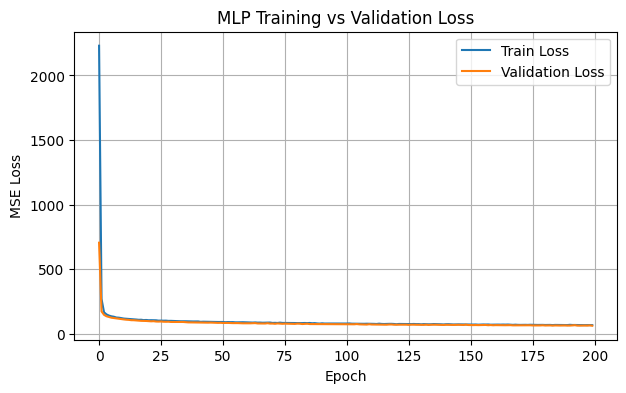

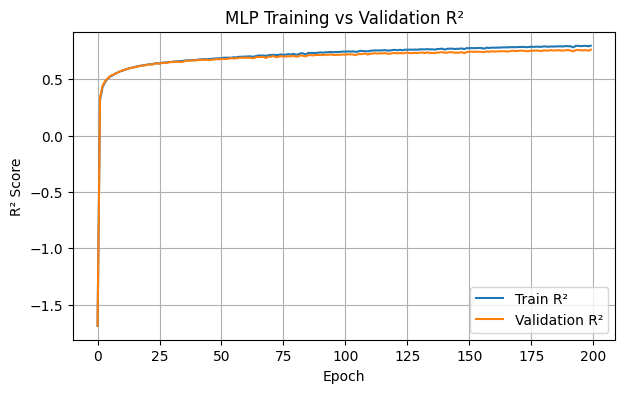

Final Test Performance of Best MLP ([256, 128]):
R² Score: 0.7303
MAE: 6.24
RMSE: 7.98


In [9]:
# Best architecture from the sweep
best_arch = [256, 128]

# Rebuild the model
torch.manual_seed(42)
best_model = MLPRegressor(
    input_dim=X_train.shape[1],
    hidden_layers=best_arch,
    dropout=0.1
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

# Tracking curves
train_losses, val_losses = [], []
train_r2_list, val_r2_list = [], []

max_epochs = 200
patience = 15
best_val_loss = float('inf')
epochs_no_improve = 0
best_state = None

for epoch in range(1, max_epochs + 1):

    train_loss = train_one_epoch(best_model, train_loader, optimizer, criterion, device)
    train_true, train_pred = evaluate(best_model, train_loader, device)
    train_r2 = r2_score(train_true, train_pred)

    val_true, val_pred = evaluate(best_model, val_loader, device)
    val_loss = ((val_true - val_pred)**2).mean()
    val_r2 = r2_score(val_true, val_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_r2_list.append(train_r2)
    val_r2_list.append(val_r2)

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_state = best_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Restore best model
best_model.load_state_dict(best_state)

#plot
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("MLP Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(7,4))
plt.plot(train_r2_list, label="Train R²")
plt.plot(val_r2_list, label="Validation R²")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("MLP Training vs Validation R²")
plt.legend()
plt.grid(True)
plt.show()

ytest_true, ytest_pred = evaluate(best_model, test_loader, device)
r2, mae, rmse = score_metrics(ytest_true, ytest_pred)
print(f"Final Test Performance of Best MLP ({best_arch}):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


The training and validation curves show that the neural network learns steadily and consistently over time.

- On the MSE loss plot, both training and validation loss decrease smoothly and remain close to each other, indicating good generalization and no major overfitting.

- On the R² plot, performance quickly rises during the first epochs and then gradually improves until stabilizing around 0.72, which aligns with the best architecture found in the sweep.

Overall, these curves demonstrate that the selected architecture learns a meaningful nonlinear mapping from the financial and environmental predictors to the ESG_Overall score, while maintaining stable validation performance—confirming that this architecture is a reasonable choice for our regression setup.

## New Regression Target: Predicting *Market Capitalization*

To extend our regression analysis beyond ESG scoring, we now focus on predicting **MarketCap**, one of the most financially meaningful variables in the dataset. This task is particularly interesting because it allows us to investigate whether ESG metrics and environmental/operational indicators have explanatory power over a company’s market valuation.

### Why is MarketCap an interesting target?

Predicting MarketCap provides insights into the potential financial relevance of ESG performance:

- **Direct link to our research question:** It helps assess whether companies with stronger ESG attributes tend to exhibit higher valuations.
- **Real-world financial impact:** Market capitalization is a key metric used by investors, analysts, and portfolio managers, making the task highly relevant.
- **Multidimensional influence:** MarketCap depends on growth, profitability, risk, sector, and potentially ESG factors—making it an excellent test case for evaluating nonlinear models.
- **Opportunity to compare models:** Ensemble methods (Random Forest, Gradient Boosting, XGBoost) often excel at modeling complex interactions, allowing us to explore whether ESG contributes any predictive signal beyond classical financial variables.

By analyzing the predictability of MarketCap, we bridge ESG analytics with tangible financial outcomes, reinforcing the financial–ESG connection central to this project.


### Decision Tree Regression — Predicting Market Capitalization

To model *MarketCap*, we begin with a Decision Tree Regressor.  
Decision trees can naturally capture nonlinear relationships between financial indicators, ESG variables, and operational metrics. This makes them a good first baseline for understanding how structured and nonlinear the relationship between ESG features and market valuation might be.

The tree is trained using the same preprocessing pipeline as before (feature engineering, one-hot encoding, standardization, and 60/20/20 split).  
We evaluate performance using R², MAE, and RMSE.


In [ ]:
df_mc = df.copy()

df_mc["EmissionsPerRevenue"] = df_mc["CarbonEmissions"] / df_mc["Revenue"]
df_mc["LogRevenue"] = np.log1p(df_mc["Revenue"])
df_mc["LogMarketCap"] = np.log1p(df_mc["MarketCap"])

df_mc = pd.get_dummies(df_mc, columns=["Industry", "Region"], drop_first=True)
mc_features = [
    "LogRevenue", "ProfitMargin", "LogMarketCap", "GrowthRate",
    "EmissionsPerRevenue", "WaterUsage", "EnergyConsumption",
    "ESG_Environmental", "ESG_Social", "ESG_Governance"
]

mc_features += [c for c in df_mc.columns if c.startswith("Industry_") or c.startswith("Region_")]

X = df_mc[mc_features].values
y = df_mc["MarketCap"].values   # direct scale

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


tree_mc = DecisionTreeRegressor(
    max_depth=None,          # tree grows fully
    min_samples_leaf=1,
    random_state=42
)

tree_mc.fit(X_train, y_train)
y_pred_tree_mc = tree_mc.predict(X_test)

r2_mc   = r2_score(y_test, y_pred_tree_mc)
mae_mc  = mean_absolute_error(y_test, y_pred_tree_mc)
rmse_mc = np.sqrt(mean_squared_error(y_test, y_pred_tree_mc))

print("Decision Tree Regression — MarketCap")
print(f"R² Score: {r2_mc:.4f}")
print(f"MAE: {mae_mc:.4f}")
print(f"RMSE: {rmse_mc:.4f}")


Decision Tree Regression — MarketCap
R² Score: 0.9531
MAE: 556.0987
RMSE: 10103.8024


The Decision Tree model demonstrates excellent predictive power for MarketCap, achieving an **R² score of 0.9531**, which indicates that it explains over 95% of the variance in company valuations. Although the RMSE appears large due to the naturally wide numerical scale of market capitalizations, the MAE remains relatively low in comparison, reflecting strong accuracy at the individual-prediction level. Overall, these results show that MarketCap is highly learnable from the available financial, sectoral, and ESG-related features, and that even a single nonlinear tree can effectively capture most of the underlying structure.








### Random Forest - Market Cap

In [ ]:
rf_mc = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_mc.fit(X_train, y_train)

y_pred_rf_mc = rf_mc.predict(X_test)

r2_rf_mc   = r2_score(y_test, y_pred_rf_mc)
mae_rf_mc  = mean_absolute_error(y_test, y_pred_rf_mc)
rmse_rf_mc = np.sqrt(mean_squared_error(y_test, y_pred_rf_mc))

print("Random Forest Regression — MarketCap")
print(f"R² Score: {r2_rf_mc:.4f}")
print(f"MAE: {mae_rf_mc:.4f}")
print(f"RMSE: {rmse_rf_mc:.4f}")

Random Forest Regression — MarketCap
R² Score: 0.9906
MAE: 298.0796
RMSE: 4524.5583


The Random Forest Regressor achieves **outstanding predictive performance** on the MarketCap regression task, with an **R² of 0.9906**, meaning it explains more than **99% of the variance** in market capitalization.  
Error metrics also confirm this strong fit:

- **MAE ≈ 298** → on average, predictions deviate by only \$298M  
- **RMSE ≈ 4525** → larger errors remain extremely small relative to the scale of multi-billion MarketCaps  

These results highlight the model’s ability to capture **complex nonlinear interactions** between financial variables, ESG sub-scores, and environmental efficiency indicators. Compared to the decision tree, the ensemble structure drastically reduces variance and stabilizes predictions.  

Overall, this experiment demonstrates that **MarketCap is highly predictable** from a combination of operational, financial, and ESG features—suggesting that ESG metrics carry **meaningful financial signal** when combined with traditional determinants of firm valuation.
